In [1]:
import pickle
import torch
import os
import copy
import numpy as np
import matplotlib.pyplot as plt

from torch_geometric.data import InMemoryDataset, Data, DataLoader
from torch_geometric.utils import to_undirected
from rdkit import Chem
from rdkit.Chem.rdDistGeom import EmbedMolecule, EmbedMultipleConfs
from typing import List
from tqdm import tqdm
from rdkit.Chem.rdMolAlign import GetBestRMS
from ccdc.conformer import ConformerGenerator
from ccdc.molecule import Molecule
from ccdc.descriptors import MolecularDescriptors
from rdkit.Geometry.rdGeometry import Point3D
from rdkit.Chem.TorsionFingerprints import GetTFDBetweenConformers
from rdkit.Chem.TorsionFingerprints import CalculateTorsionLists
from rdkit.Chem.rdMolTransforms import GetDihedralDeg, SetDihedralDeg
from collections import defaultdict
from torch_geometric.data import Batch

In [2]:
from ipywidgets import interact,fixed,IntSlider
import ipywidgets
import py3Dmol

In [3]:
from litschnet import LitSchNet
from molecule_encoders import MoleculeEncoders
from molecule_featurizer import MoleculeFeaturizer
from mol_viewer import MolViewer
from ccdc_rdkit_connector import CcdcRdkitConnector

In [4]:
data_dir = 'data/'
pdbbind_refined_dir = '/home/benoit/PDBBind/PDBbind_v2020_refined/refined-set/'
pdbbind_general_dir = '/home/benoit/PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'

In [5]:
with open(os.path.join(data_dir, 'random_splits', f'test_smiles_random_split_0.txt'), 'r') as f :
    test_smiles = f.readlines()
    test_smiles = [smiles.strip() for smiles in test_smiles]
    
with open(os.path.join(data_dir, 'raw', 'ccdc_generated_conf_ensemble_library.p'), 'rb') as f :
    cel = pickle.load(f)

In [6]:
connector = CcdcRdkitConnector()

encoder_path = os.path.join(data_dir, 'molecule_encoders.p')
if os.path.exists(encoder_path) : # Load existing encoder
    with open(encoder_path, 'rb') as f:
        mol_encoders = pickle.load(f)
mol_featurizer = MoleculeFeaturizer(mol_encoders)

experiment_name = f'random_split_0_new'
if experiment_name in os.listdir('lightning_logs') :
    checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
    checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
    litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
litschnet.eval()

LitSchNet(
  (schnet): SchNet(hidden_channels=128, num_filters=128, num_interactions=6, num_gaussians=50, cutoff=10.0)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (sigmoid): Sigmoid()
)

In [7]:
mol_viewer = MolViewer()

In [8]:
def data_list_to_conf_ensemble(data_list, mol) :
    new_mol = copy.deepcopy(mol)
    n_gen = len(data_list) - mol.GetNumConformers()
    for data in data_list[-n_gen:] :
        dummy_mol = copy.deepcopy(mol)
        new_conf = dummy_mol.GetConformer()
        for ai, pos in enumerate(new_conf.GetPositions()) :
            point3d = Point3D(*data.pos[ai].numpy().tolist())
            new_conf.SetAtomPosition(ai, point3d)
        new_mol.AddConformer(new_conf, assignId=True)
    return new_mol

In [9]:
def explore_torsion_space(mol, litschnet) :
    data_list = mol_featurizer.featurize_mol(mol)
    batch = Batch.from_data_list(data_list)
    rmsd = mol_featurizer.get_bioactive_rmsds(mol)
    pred_rmsd = litschnet(batch)
    plt.scatter(rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()

    mol_viewer.view(mol)
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
    n_gen = len(generated_ids)
    
    for torsion_atoms in torsions :
        angles = range(-180, 180, 1)
        explore_data_list = []
        for angle in angles :
            dummy_mol = copy.deepcopy(mol) 
            conf = dummy_mol.GetConformer(0)
            SetDihedralDeg(conf, *torsion_atoms, angle)
            data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
            explore_data_list.append(data)

        loader = DataLoader(explore_data_list, batch_size=24)
        pred_rmsd = []
        for batch in loader :
            pred = litschnet(batch)
            pred_rmsd.extend(pred.detach().numpy().tolist())

        plt.figure(figsize=(10,5))
        plt.plot(angles, pred_rmsd)
        plt.xlabel('Torsion angle')
        plt.ylabel('Predicted RMSD')
        plt.axvline(GetDihedralDeg(mol.GetConformer(0), *torsion_atoms), label='Bioactive', c='green', linewidth=5)
        for generated_id in generated_ids :
            conf = mol.GetConformer(generated_id)
            plt.axvline(GetDihedralDeg(conf, *torsion_atoms), c='red', label='Generated')
            
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())
        plt.show()

In [10]:
def explore_torsion_space_2d(mol, litschnet) :
    data_list = mol_featurizer.featurize_mol(mol)
    batch = Batch.from_data_list(data_list)
    rmsd = mol_featurizer.get_bioactive_rmsds(mol)
    pred_rmsd = litschnet(batch)
    plt.scatter(rmsd, pred_rmsd.detach())
    plt.xlabel('Bioactive RMSD')
    plt.ylabel('Predicted RMSD')
    plt.show()

    mol_viewer.view(mol)
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    
    generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
    n_gen = len(generated_ids)
    
    for i, torsion_atoms1 in enumerate(torsions) :
        for torsion_atoms2 in torsions[i+1:] :
            angles = list(range(-180, 180, 5))
            explore_data_list = []
            for angle1 in angles :
                for angle2 in angles :
                    dummy_mol = copy.deepcopy(mol) 
                    conf = dummy_mol.GetConformer(0)
                    SetDihedralDeg(conf, *torsion_atoms1, angle1)
                    SetDihedralDeg(conf, *torsion_atoms2, angle2)
                    data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
                    explore_data_list.append(data)
                
            loader = DataLoader(explore_data_list, batch_size=24)
            pred_rmsd = []
            for batch in loader :
                pred = litschnet(batch)
                pred_rmsd.extend(pred.detach().numpy().tolist())
                
            pred_rmsd = np.array(pred_rmsd).reshape(len(angles), len(angles))

            fig = plt.figure(figsize=(10,5))
            ax = fig.add_subplot(111)
            cax = ax.matshow(pred_rmsd, extent=[-180, 180, -180, 180])
            fig.colorbar(cax)
            plt.xlabel('Angle1')
            plt.ylabel('Angle2')
            real_torsion1 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms1)
            real_torsion2 = GetDihedralDeg(mol.GetConformer(0), *torsion_atoms2)
            ax.set_title(f'{torsion_atoms1} : {int(real_torsion1)} X {torsion_atoms2} : {int(real_torsion2)}')
            plt.show()

In [11]:
all_smiles = [smiles for smiles, ce in cel.get_unique_molecules()]

In [12]:
mol = cel.get_conf_ensemble(all_smiles[0]).mol

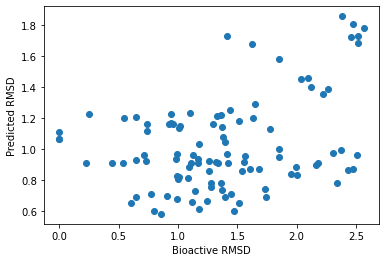

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/ipykernel/pylab/backend_inline.py:14: DeprecationWarning: `ipykernel.pylab.backend_inline` is deprecated, directly use `matplotlib_inline.backend_inline`
  DeprecationWarning


interactive(children=(IntSlider(value=0, description='conf_id', max=102), Output()), _dom_classes=('widget-int…

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


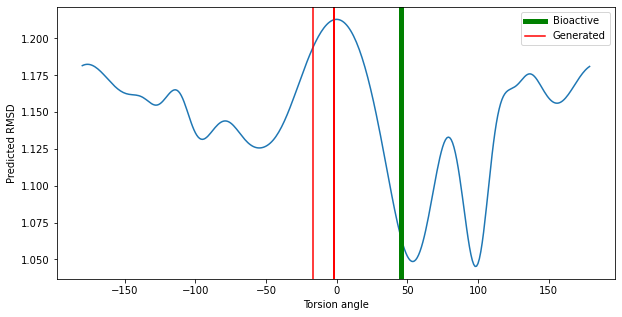

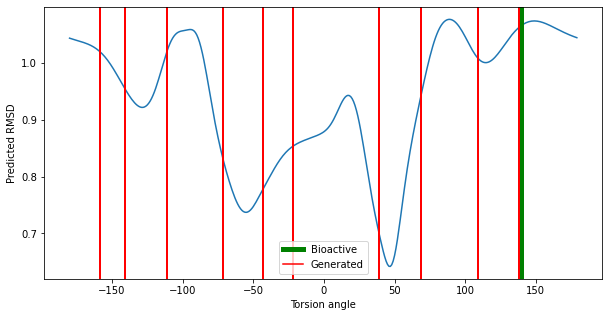

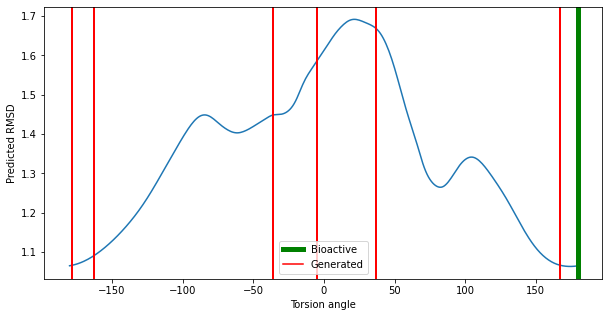

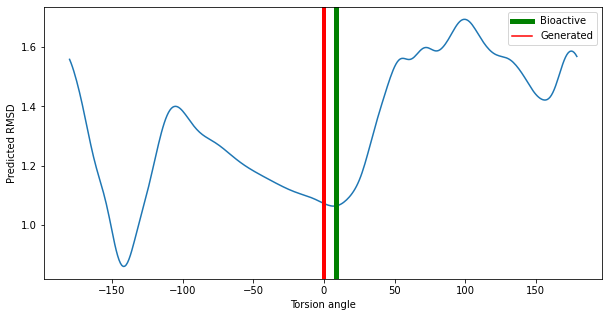

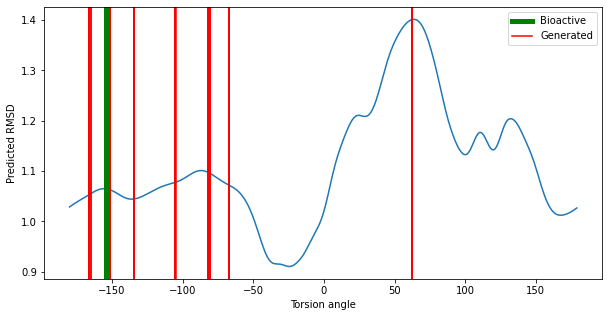

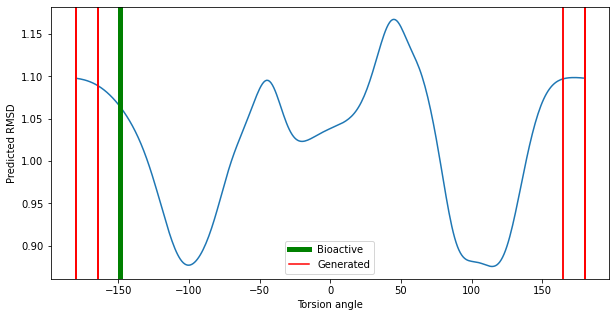

In [13]:
explore_torsion_space(mol, litschnet)

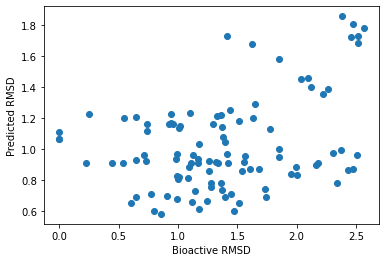

interactive(children=(IntSlider(value=0, description='conf_id', max=102), Output()), _dom_classes=('widget-int…

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


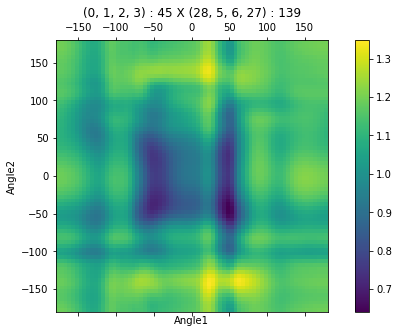

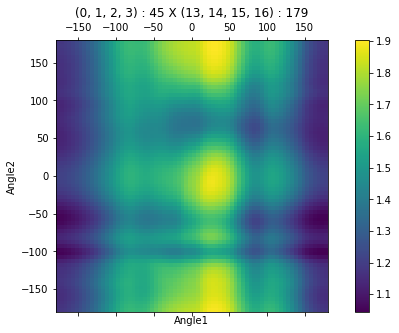

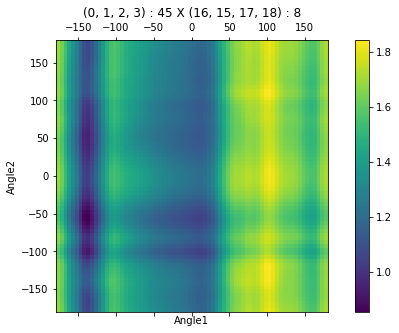

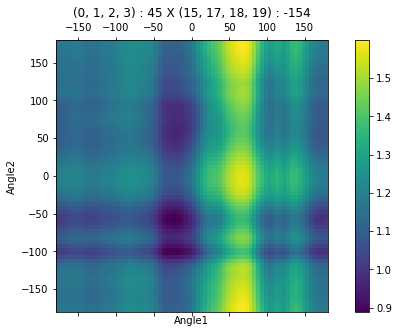

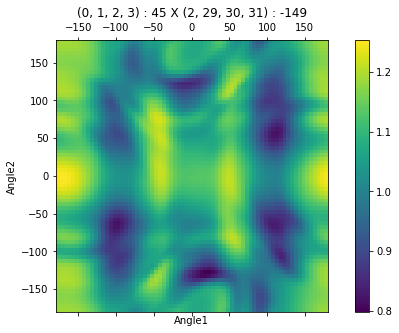

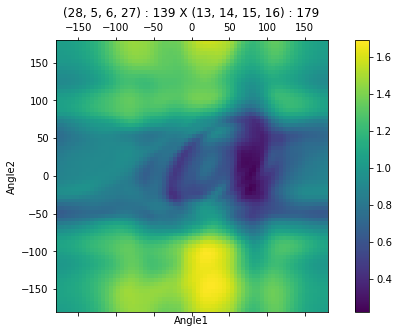

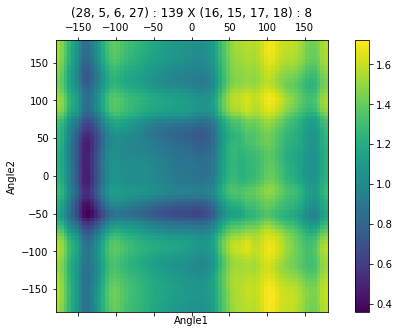

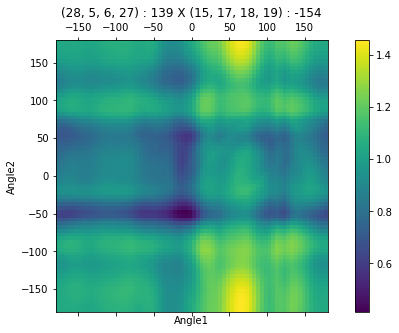

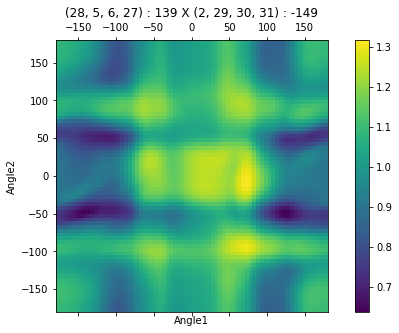

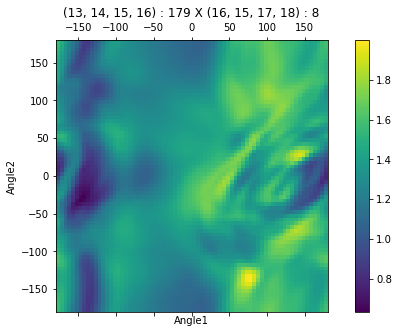

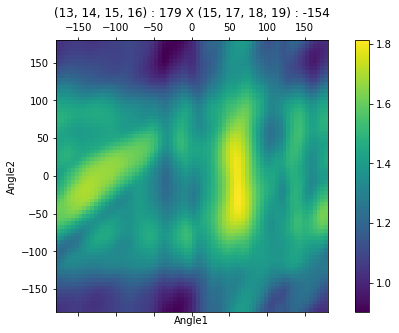

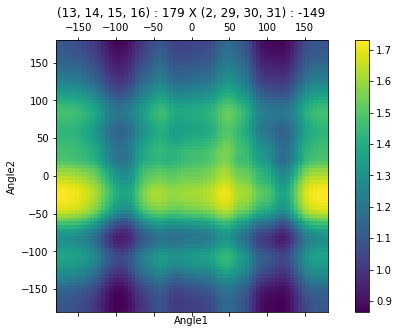

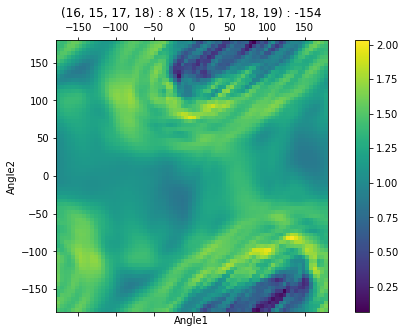

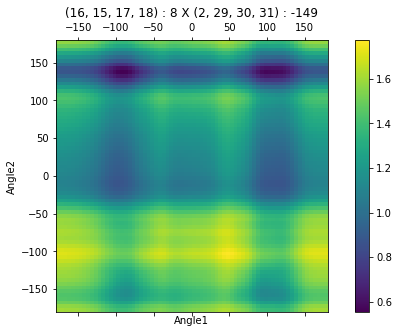

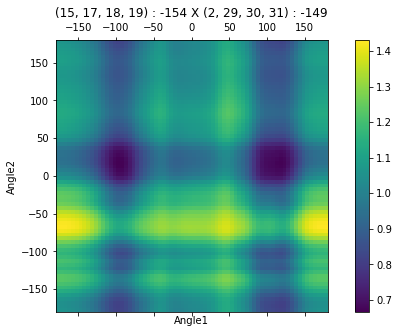

In [14]:
explore_torsion_space_2d(mol, litschnet)

In [15]:
def scoring_function(inputs, data_list, mol, torsions) :
    dummy_mol = copy.deepcopy(mol)
    conf = dummy_mol.GetConformer(0)
    for i, input in enumerate(inputs) :
        SetDihedralDeg(conf, *torsions[i], input)
    data = mol_featurizer.conf_to_data(rdkit_mol=dummy_mol, conf_id=0, edge_index=data_list[0].edge_index, z=data_list[0].z)
    data_list = [data]
    batch = Batch.from_data_list(data_list)
    pred_rmsd = litschnet(batch).detach().numpy()
    output = pred_rmsd[0][0]
    return output

In [16]:
from scipy.optimize import minimize

In [17]:
def ccdc_rmsd_rdkit_mol(rdkit_mol, conf_id1, conf_id2) :
    molblock1 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id1)
    molblock2 = Chem.MolToMolBlock(rdkit_mol, confId=conf_id2)
    ccdc_mol1 = Molecule.from_string(molblock1)
    ccdc_mol2 = Molecule.from_string(molblock2)
    return MolecularDescriptors.overlay_rmsds_and_transformation(ccdc_mol1, ccdc_mol2)[1]

In [18]:
from scipy.spatial import distance_matrix
def has_clash(rdkit_mol, conf_id) :
    conf = rdkit_mol.GetConformer(conf_id)
    positions = conf.GetPositions()
    dm = distance_matrix(positions, positions)
    values = [value for l in dm for value in l if value != 0]     
    return np.array(values).min() < 0.5

In [19]:
def optimize_torsions(mol, 
                      view_mol=False, 
                      verbose=False) :
    
    torsions = [torsion_hit[0][0] for torsion_hit in CalculateTorsionLists(mol)[0]]
    data_list = mol_featurizer.featurize_mol(mol)
    xbioactive = [GetDihedralDeg(mol.GetConformer(0), *torsion_atoms) for torsion_atoms in torsions]
    try :
        generated_ids = [conf.GetId() for conf in mol.GetConformers() if conf.HasProp('Generator')]
        n_gen = len(generated_ids)
        gen_conf_id = generated_ids[0]

        x0 = [GetDihedralDeg(mol.GetConformer(gen_conf_id), *torsion_atoms) for torsion_atoms in torsions]
        #print(x0)

        opt = minimize(scoring_function, x0, args=(data_list, mol, torsions), method='Nelder-Mead')
        #print(f'Optimal predicted RMSD : {opt.fun}')
        solution = opt.x
        
#         print([int(x) for x in xbioactive])
#         print([int(x) for x in x0])
#         print([int(x) for x in solution])

        new_mol = copy.deepcopy(mol)
        new_mol.RemoveAllConformers()
        new_mol.AddConformer(mol.GetConformer(0), assignId=True)

        dummy_mol = copy.deepcopy(new_mol)
        optimized_conf = dummy_mol.GetConformer(0)
        for i, angle in enumerate(solution) :
            SetDihedralDeg(optimized_conf, *torsions[i], angle)
        optimized_conf_id = new_mol.AddConformer(optimized_conf, assignId=True)
        
        rmsd_optimized_to_bioactive = ccdc_rmsd_rdkit_mol(new_mol, 0, optimized_conf_id)

        gen_conf_id = new_mol.AddConformer(mol.GetConformer(gen_conf_id), assignId=True)
        rmsd_generated_to_bioactive = ccdc_rmsd_rdkit_mol(new_mol, 0, gen_conf_id)
        
        rmsd_optimized_to_generated = ccdc_rmsd_rdkit_mol(new_mol, optimized_conf_id, gen_conf_id)
        
        clash = has_clash(new_mol, optimized_conf_id)
        if verbose :
            print(f'Has clash: {clash}')
            print(f'RMSD optimized to bioactive : {rmsd_optimized_to_bioactive}')
            print(f'RMSD generated to bioactive : {rmsd_generated_to_bioactive}')
            print(f'RMSD generated to bioactive : {rmsd_optimized_to_generated}')
        
        if view_mol :
            mol_viewer.view(new_mol)

        return rmsd_optimized_to_bioactive, rmsd_generated_to_bioactive, rmsd_optimized_to_generated, opt.fun, clash 
        
    except Exception as e:
        print('Error in generation')
        print(str(e))

In [20]:
for smiles in tqdm(test_smiles) :
    mol = cel.get_conf_ensemble(smiles).mol
    try :
        rob, rgb, rog, pred, clash = optimize_torsions(mol)
        if clash :
            rob, rgb, rog, pred, clash = optimize_torsions(mol, view_mol=True, verbose=True)
            break
    except :
        print('Energy problem')

  4%|█▌                                     | 44/1110 [03:54<2:05:19,  7.05s/it]RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
[13:12:00] UFFTYPER: Unrecognized charge state for atom: 9
RDK

Energy problem


  5%|█▉                                     | 56/1110 [04:52<1:34:28,  5.38s/it]

Energy problem


 11%|████▏                                 | 123/1110 [09:45<2:09:21,  7.86s/it]

Energy problem


 12%|████▍                                 | 131/1110 [10:27<1:33:20,  5.72s/it]

Energy problem


 15%|█████▊                                | 168/1110 [13:12<1:04:58,  4.14s/it]

Energy problem


 19%|███████                               | 206/1110 [16:14<2:28:28,  9.86s/it]RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [13:24:20] UFFTYPER: Unrecognized charge state for atom: 11
[13:24:20] UFFTYPER: Unrecognized charge state fo

Energy problem


 25%|█████████▍                            | 276/1110 [22:01<2:13:53,  9.63s/it]

Energy problem


 31%|████████████▎                           | 343/1110 [27:21<27:56,  2.19s/it]

Energy problem


 46%|██████████████████▎                     | 508/1110 [39:34<22:50,  2.28s/it]

Energy problem


 51%|████████████████████▌                   | 571/1110 [46:00<30:09,  3.36s/it]

Energy problem


 65%|██████████████████████████▏             | 725/1110 [56:14<16:21,  2.55s/it]RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
[14:04:20] UFFTYPER: Unrecognized charge state for atom: 1
RDK

Energy problem


 66%|██████████████████████████▍             | 733/1110 [56:45<43:26,  6.92s/it]

Energy problem


 70%|██████████████████████████▋           | 781/1110 [1:00:56<39:18,  7.17s/it]

Energy problem


 74%|████████████████████████████▏         | 822/1110 [1:03:58<29:33,  6.16s/it]

Energy problem


 76%|████████████████████████████▊         | 843/1110 [1:05:51<23:02,  5.18s/it]RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [14:13:57] UFFTYPER: Unrecognized charge state for atom: 13
[14:13:57] UFFTYPER: Unrecognized charge state fo

Energy problem


 77%|█████████████████████████████▍        | 860/1110 [1:06:57<23:37,  5.67s/it]

Energy problem


 79%|██████████████████████████████        | 878/1110 [1:08:58<18:18,  4.74s/it]

Energy problem


 81%|██████████████████████████████▋       | 895/1110 [1:10:38<19:31,  5.45s/it]

Energy problem
Energy problem


 82%|███████████████████████████████▏      | 910/1110 [1:11:21<08:25,  2.53s/it]RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
[14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [14:19:28]

Energy problem


 86%|████████████████████████████████▌     | 950/1110 [1:14:04<12:52,  4.83s/it]

Energy problem


 92%|██████████████████████████████████   | 1022/1110 [1:19:25<03:44,  2.55s/it]

Energy problem
Energy problem


 99%|████████████████████████████████████▌| 1096/1110 [1:24:34<00:43,  3.11s/it]

Energy problem


100%|█████████████████████████████████████| 1110/1110 [1:25:34<00:00,  4.63s/it]


In [19]:
robs = []
rgbs = []
rogs = []
preds = []
gains = []
for smiles in tqdm(test_smiles) :
    mol = cel.get_conf_ensemble(smiles).mol
    try :
        rob, rgb, rog, pred = optimize_torsions(mol)
        gain = rob - rgb
        robs.append(rob)
        rgbs.append(rgb)
        rogs.append(rog)
        preds.append(pred)
        gains.append(gain)
    except Exception as e:
        print(f'Error for smiles {smiles}')
        print(str(e))

  4%|█▌                                     | 44/1110 [16:20<2:43:19,  9.19s/it]RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
[17:31:24] UFFTYPER: Unrecognized charge state for atom: 9
RDKit ERROR: [17:31:24] UFFTYPER: Unrecognized charge state fo

Error for smiles CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@H]1CO[C@H]2OCC[C@@H]12)S(=O)(=O)c1ccc(B(O)O)cc1
'NoneType' object has no attribute 'CalcEnergy'


  5%|█▉                                     | 56/1110 [17:24<1:37:49,  5.57s/it]

Error for smiles O=S(=O)(NCB(O)O)c1ccc(-c2nn[nH]n2)cc1C(F)(F)F
'NoneType' object has no attribute 'CalcEnergy'


 11%|████▏                                 | 123/1110 [22:34<2:11:43,  8.01s/it]

Error for smiles CC#CC[Se]c1ccc(S(N)(=O)=O)cc1
'NoneType' object has no attribute 'CalcEnergy'


 12%|████▍                                 | 131/1110 [23:16<1:32:22,  5.66s/it]

Error for smiles Nc1cccc(B(O)O)c1
'NoneType' object has no attribute 'CalcEnergy'


 15%|█████▊                                | 168/1110 [26:05<1:06:02,  4.21s/it]

Error for smiles O=C1C[N@@+]23Cc4cccc[n+]4[Fe+7]245(O1)OC(=O)C[N@+]4(Cc1cccc[n+]15)[C@@H]1CCCC[C@H]13
'NoneType' object has no attribute 'CalcEnergy'


 19%|███████                               | 206/1110 [29:20<2:38:11, 10.50s/it]RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
[17:44:24] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:25] UFFTYPER: Unrecognized charge state for atom: 11
RDKit ERROR: [17:44:25] UFFTYPER: Unrecognized ch

Error for smiles O=C([O-])c1cccc(/C=C/c2ccc(B(O)O)cc2)c1
'NoneType' object has no attribute 'CalcEnergy'


 25%|█████████▍                            | 276/1110 [35:21<2:16:21,  9.81s/it]

Error for smiles CC12C3(C)[C@]4(C)[C@@]5(C)[C@]1(C)[Ir+9]23451([ClH+])[n+]2ccc(O)cc2C(=O)[N@H+]1/C=C/c1ccc(S(N)(=O)=O)cc1
'NoneType' object has no attribute 'CalcEnergy'


 31%|████████████▎                           | 343/1110 [40:56<28:32,  2.23s/it]

Error for smiles CC1=CC2=[N+]3C1=CC1=[N+]4C(=CC5=[N+]6C(=CC7=[N+](C(=C2)C(C)=C7)[Mg@@-2]346)C(C)=C5CCC(=O)[O-])C(CCC(=O)[O-])=C1C
'NoneType' object has no attribute 'CalcEnergy'


 46%|██████████████████▎                     | 508/1110 [53:40<24:47,  2.47s/it]

Error for smiles O=S(=O)(NCB(O)O)c1ccc(-c2nnn[nH]2)cc1
'NoneType' object has no attribute 'CalcEnergy'


 51%|███████████████████▌                  | 571/1110 [1:00:30<31:51,  3.55s/it]

Error for smiles C=CC[Se]c1ccc(S(N)(=O)=O)cc1
'NoneType' object has no attribute 'CalcEnergy'


 65%|████████████████████████▊             | 725/1110 [1:11:32<18:03,  2.81s/it]RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDKit ERROR: [18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
[18:26:36] UFFTYPER: Unrecognized charge state for atom: 1
RDK

Error for smiles CC(C)(C)OC(=O)Nc1cccc(B(O)O)c1
'NoneType' object has no attribute 'CalcEnergy'


 66%|█████████████████████████             | 733/1110 [1:12:03<43:09,  6.87s/it]

Error for smiles [NH3+][C@@](CCC[CH2]~B(O)(O)O)(C(=O)[O-])C(F)F
'NoneType' object has no attribute 'CalcEnergy'


 70%|██████████████████████████▋           | 781/1110 [1:16:23<41:59,  7.66s/it]

Error for smiles NC(=[NH2+])c1ccc([C@@H]2Cc3ccccc3B([OH2+])O2)cc1
'NoneType' object has no attribute 'CalcEnergy'


 74%|████████████████████████████▏         | 822/1110 [1:19:36<31:32,  6.57s/it]

Error for smiles C[C]1O[Fe+7]23(O[NH2+]CCCCC[NH3+])(O/C=C\CC(=O)NCCCCCN1O2)OCCCC(=O)NCCCCC[NH2+]O3
'NoneType' object has no attribute 'CalcEnergy'


 76%|████████████████████████████▊         | 843/1110 [1:21:35<23:49,  5.36s/it]RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
RDKit ERROR: [18:36:39] UFFTYPER: Unrecognized charge state for atom: 13
[18:36:39] UFFTYPER: Unrecognized charge state fo

Error for smiles CC(C)CN(C[C@@H](O)[C@H](Cc1ccccc1)NC(=O)O[C@@H]1[C@@H]2CO[C@@H]3OC[C@H]1C[C@@H]32)S(=O)(=O)c1ccc(B([OH2+])[OH2+])cc1
'NoneType' object has no attribute 'CalcEnergy'


 77%|█████████████████████████████▍        | 860/1110 [1:22:45<25:27,  6.11s/it]

Error for smiles OB(O)c1ccc(-c2ccc(B(O)O)cc2)cc1
'NoneType' object has no attribute 'CalcEnergy'


 79%|██████████████████████████████        | 878/1110 [1:24:56<19:05,  4.94s/it]

Error for smiles O=S(=O)(Nc1cccc(B(O)O)c1)c1cc(S(=O)(=O)c2ccccc2)cs1
'NoneType' object has no attribute 'CalcEnergy'


 81%|██████████████████████████████▋       | 895/1110 [1:26:40<20:25,  5.70s/it]

Error for smiles CC12C3(C)C4(C)C5(C)C1(C)[Ir+9]23451([ClH+])[n+]2ccc(O)cc2C(=O)[N@@H+]1CCCc1ccc(S(N)(=O)=O)cc1
'NoneType' object has no attribute 'CalcEnergy'
Error for smiles NC(=[NH2+])c1ccc([C@@H]2Cc3ccccc3B([OH2+])O2)cc1OCc1cccnc1
'NoneType' object has no attribute 'CalcEnergy'


 82%|███████████████████████████████▏      | 910/1110 [1:27:26<09:00,  2.70s/it]RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
[18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Unrecognized atom type: N_ (3)
RDKit ERROR: [18:42:30] UFFTYPER: Un

Error for smiles c1ccc2c3n4c(c2c1)[N-]c1c2ccccc2c2n1[FeH2+7]41n4c(c5ccccc5c4[N-]c4c5ccccc5c(n41)[N-]2)[N-]3
'NoneType' object has no attribute 'CalcEnergy'


 86%|████████████████████████████████▌     | 950/1110 [1:30:20<13:48,  5.18s/it]

Error for smiles CC(=O)N[C@@H](Cc1cccc2ccccc12)B(O)O
'NoneType' object has no attribute 'CalcEnergy'


 92%|██████████████████████████████████   | 1022/1110 [1:36:03<04:20,  2.96s/it]

Error for smiles CS(=O)(=O)c1cc(NS(=O)(=O)c2cc(Br)ccc2O)cc(S(F)(F)(F)(F)F)c1
'NoneType' object has no attribute 'CalcEnergy'
Error for smiles CCCCCCCCB([OH2+])[OH2+]
'NoneType' object has no attribute 'CalcEnergy'


 99%|████████████████████████████████████▌| 1096/1110 [1:41:37<00:46,  3.33s/it]

Error for smiles O=C1C[C@]2(O)CC(=O)O[Fe+7]34(O1)(OC(=O)C[C@](O)(CC(=O)O3)C(=O)O4)OC2=O
'NoneType' object has no attribute 'CalcEnergy'


100%|█████████████████████████████████████| 1110/1110 [1:42:45<00:00,  5.55s/it]


In [20]:
import seaborn as sns

In [21]:
all_values = []
all_targets = []

all_values.extend(robs)
all_targets.extend(['ROBS' for _ in robs])

all_values.extend(rgbs)
all_targets.extend(['RGBS' for _ in rgbs])

all_values.extend(rogs)
all_targets.extend(['ROGS' for _ in rogs])

all_values.extend(preds)
all_targets.extend(['Preds' for _ in preds])

In [22]:
import pandas as pd
df = pd.DataFrame()

In [23]:
df['values'] = pd.Series(all_values)
df['targets'] = pd.Series(all_targets)

<AxesSubplot:xlabel='targets', ylabel='values'>

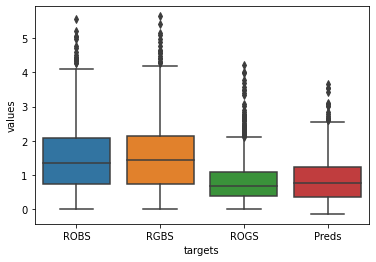

In [24]:
sns.boxplot(data=df, x='targets', y='values')

<AxesSubplot:xlabel='values', ylabel='Density'>

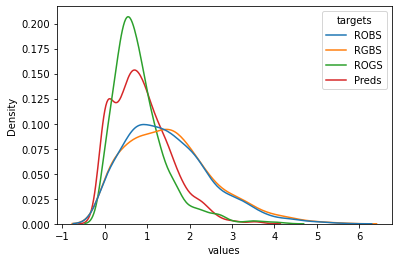

In [25]:
sns.kdeplot(data=df, x='values', hue='targets')

<AxesSubplot:>

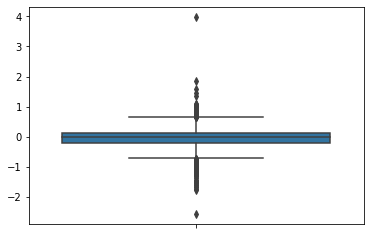

In [26]:
sns.boxplot(y=gains)